# Create maps showing average IMD for each IVT unit catchment

Using the datafile as created from notebook 02_combine_demographic_data.ipynb, create maps of IMD for each IVT unit, showing the weighted population average.

To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb

Import libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import os
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

Read in Index of Multiple Deprivation data (per LSOA)

In [2]:
df_lsoa = pd.read_csv('./data/collated_data.csv')
#df_lsoa.set_index(['LSOA'], inplace=True)

Look at first few rows

In [3]:
df_lsoa.head()

,LSOA,admissions,closest_ivt_unit,closest_ivt_time,closest_mt_unit,closest_mt_time,mt_transfer_time,ivt_rate,Local Authority District name (2019),Income Domain Score,...,age band males 50,age band males 55,age band males 60,age band males 65,age band males 70,age band males 75,age band males 80,age band males 85,age band males 90,age band males 95
0,Welwyn Hatfield 010F,0.666667,SG14AB,19.2,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.104,...,53.0,62.0,37.0,32.0,27.0,30.0,15.0,4.0,3.0,0.0
1,Welwyn Hatfield 012A,4.000000,SG14AB,20.3,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.176,...,58.0,63.0,43.0,36.0,25.0,14.0,15.0,9.0,7.0,0.0
2,Welwyn Hatfield 002F,2.000000,SG14AB,19.2,NW12BU,38.6,47.2,6.8,Welwyn Hatfield,0.037,...,43.0,50.0,51.0,21.0,31.0,8.0,5.0,8.0,5.0,0.0
3,Welwyn Hatfield 002E,0.666667,SG14AB,19.2,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.066,...,42.0,63.0,33.0,20.0,15.0,18.0,18.0,5.0,1.0,0.0
4,Welwyn Hatfield 010A,3.333333,SG14AB,19.2,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.113,...,56.0,54.0,37.0,32.0,28.0,21.0,12.0,9.0,2.0,0.0


Group data by "closest_ivt_unit" and calculate the weighted average of IMD (weighted by population).

NOTE: Couldn't find IMD in dataset, so for now using "Income Domain Score", and will check what to use later.

https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe

In [4]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_lsoa.loc[x.index, "All persons"])

# Define a dictionary with the functions to apply for a given column:
# the following is deprecated since pandas 0.20:
# f = {'adjusted_lots': ['sum'], 'price': {'weighted_mean' : wm} }
# df.groupby(["contract", "month", "year", "buys"]).agg(f)

# Groupby and aggregate with namedAgg [1]:
df_ivt_imd = df_lsoa.groupby(["closest_ivt_unit"]).agg(
            all_persons=("All persons", "sum"),  
            income_domain_score_weighted_mean=("Income Domain Score", wm))
df_ivt_imd

,all_persons,income_domain_score_weighted_mean
closest_ivt_unit,,
B152TH,946192.0,0.182013
B714HJ,950166.0,0.200384
BA13NG,481727.0,0.084326
BA214AT,284415.0,0.094389
BB23HH,491561.0,0.177081
...,...,...
WD180HB,609652.0,0.082740
WF14DG,597452.0,0.148566
WR51DD,406174.0,0.094492


Map the data.

Load IVT catchment shape file (created in notebook "03_create_ivt_catchment_shapefile_and_map.ipynb" by dissolving LSOA polygons that are in the same IVT unit catchment).

https://geopandas.org/aggregation_with_dissolve.html

The following will load the shape file of the catchments for the IVT units in England and Wales into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
EPSG:3857 - projection for displaying lat/long as a flat map

In [5]:
filename = "data/ivt_catchment.shp"
exist = os.path.exists(filename)

if exist:
    # Read in
    gdf_ivt_catchment = gpd.read_file(filename, crs='EPSG:27700')
else:
    print('Run "03_create_ivt_catchment_shapefile_and_map.ipynb" first')
gdf_ivt_catchment.head()

,closest_iv,LSOA11NM,LSOA11CD,LSOA11NMW,geometry
0,B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((416409.188 268044.406, 416406...."
1,B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((417821.448 275919.567, 417832...."
2,BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"MULTIPOLYGON (((390339.219 149073.312, 390339...."
3,BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((325347.501 91556.700, 325347.4..."
4,BB23HH,Bolton 001B,E01004803,Bolton 001B,"MULTIPOLYGON (((378922.528 421439.886, 379017...."


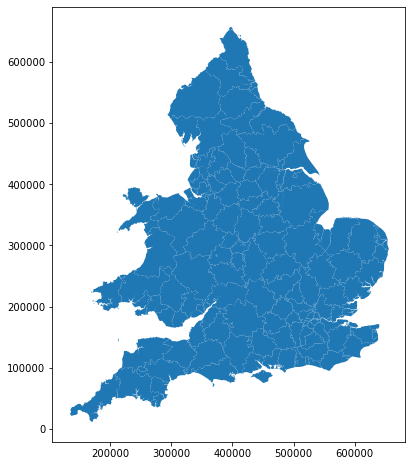

In [6]:
gdf_ivt_catchment.plot(figsize=(8,8));

Add data about IMD, joining based on 'closest_ivt_unit'

In [7]:
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)
gdf_ivt_catchment = gdf_ivt_catchment.join(df_ivt_imd['income_domain_score_weighted_mean']).reset_index()
gdf_ivt_catchment.head()

,closest_iv,LSOA11NM,LSOA11CD,LSOA11NMW,geometry,income_domain_score_weighted_mean
0,B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((416409.188 268044.406, 416406....",0.182013
1,B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((417821.448 275919.567, 417832....",0.200384
2,BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"MULTIPOLYGON (((390339.219 149073.312, 390339....",0.084326
3,BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((325347.501 91556.700, 325347.4...",0.094389
4,BB23HH,Bolton 001B,E01004803,Bolton 001B,"MULTIPOLYGON (((378922.528 421439.886, 379017....",0.177081


Mapping data with MatPlotLib (using MatPlotLib gives us more power than the GeoPandas DataFrame plot method)

Read in hospital data
(Stroke Team, SSNAP name, Easting, Northing)

In [8]:
gdf_units = gpd.read_file('./data/stroke_hospitals_2022.csv')

gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)
gdf_units = gdf_units.set_crs(epsg=27700)

# Restrict to the units delivering thrombolysis
mask = gdf_units['Use']=="1"
gdf_units = gdf_units[mask]
gdf_units.head()

,Postcode,Hospital_name,Use,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,Thrombolysis,ivt_rate,Easting,Northing,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,geometry
0,RM70AG,RM70AG,1,England,London SCN,Barking; Havering and Redbridge University Hos...,"Queen's Hospital, Romford",Queens Hospital Romford HASU,981,117,11.9,551118,187780,1,0,Romford,,POINT (551118.000 187780.000)
1,E11BB,E11BB,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,115,13.4,534829,181798,1,1,Royal London,,POINT (534829.000 181798.000)
2,SW66SX,SW66SX,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,1147,113,9.9,524226,176487,1,1,Charing Cross,,POINT (524226.000 176487.000)
3,SE59RW,SE59RW,1,England,London SCN,King's College Hospital NHS Foundation Trust,"King's College Hospital, London",King's College Hospital HASU,824,124,15,532536,176228,1,0,Kings College,,POINT (532536.000 176228.000)
4,BR68ND,BR68ND,1,England,London SCN,King's College Hospital NHS Foundation Trust,Princess Royal University Hospital; Orpington,Princess Royal University Hospital HASU,847,113,13.3,543443,165032,0,0,Princess Royal,,POINT (543443.000 165032.000)


In [9]:
# When using base maps convert data to epsg:3857
gdf_ivt_catchment = gdf_ivt_catchment.to_crs(epsg=3857)
gdf_units = gdf_units.to_crs(epsg=3857)

In [10]:
def add_nonoverlapping_text_labels(gdf_units, ax, col, y_step=0.05, fontsize=7):
    """
    #https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position


    """

    text_rectangles = []

    # Better results if the labels are sorted descending in the y axis
    gdf_units['sort_by'] = gdf_units.geometry.y
    gdf_units.sort_values("sort_by", ascending=False, inplace=True)
    del gdf_units["sort_by"]

    # Add labels
    for x, y, label in zip(
        gdf_units.geometry.x, gdf_units.geometry.y, gdf_units[col]):
            text = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points", fontsize=fontsize, 
                        bbox=dict(facecolor='w', alpha=0.3, edgecolor='none', boxstyle="round", pad=0.1))
            x, y = text.get_position()
            new_x = x - 2
            text.set_position((new_x, y))
                    
            rect = text.get_window_extent()

            for other_rect in text_rectangles:
                while Bbox.intersection(rect, other_rect):  # overlapping
                    x, y = text.get_position()
                    new_y = y - y_step
                    text.set_position((x, new_y))
                    rect = text.get_window_extent()
            text_rectangles.append(rect)
    return (ax)

In [11]:
eng_wales_bounds = gdf_ivt_catchment.bounds
eng_wales_bounds = eng_wales_bounds.merge(gdf_ivt_catchment['closest_iv'],how = 'left',
                      left_on = eng_wales_bounds.index,
                      right_on = gdf_ivt_catchment.index)
eng_wales_bounds = eng_wales_bounds.set_index('closest_iv')
eng_wales_bounds.drop('key_0', axis = 1, inplace = True)
eng_wales_bounds.head()

,minx,miny,maxx,maxy
closest_iv,,,,
B152TH,-228159.802798,6.840962e+06,-186486.338700,6.891316e+06
B714HJ,-229569.237338,6.866385e+06,-174024.968338,6.928042e+06
BA13NG,-301440.775752,6.639528e+06,-219298.476667,6.742989e+06
BA214AT,-343008.663735,6.568119e+06,-236217.122846,6.661788e+06
BB23HH,-294540.971475,7.097870e+06,-227656.461132,7.179456e+06


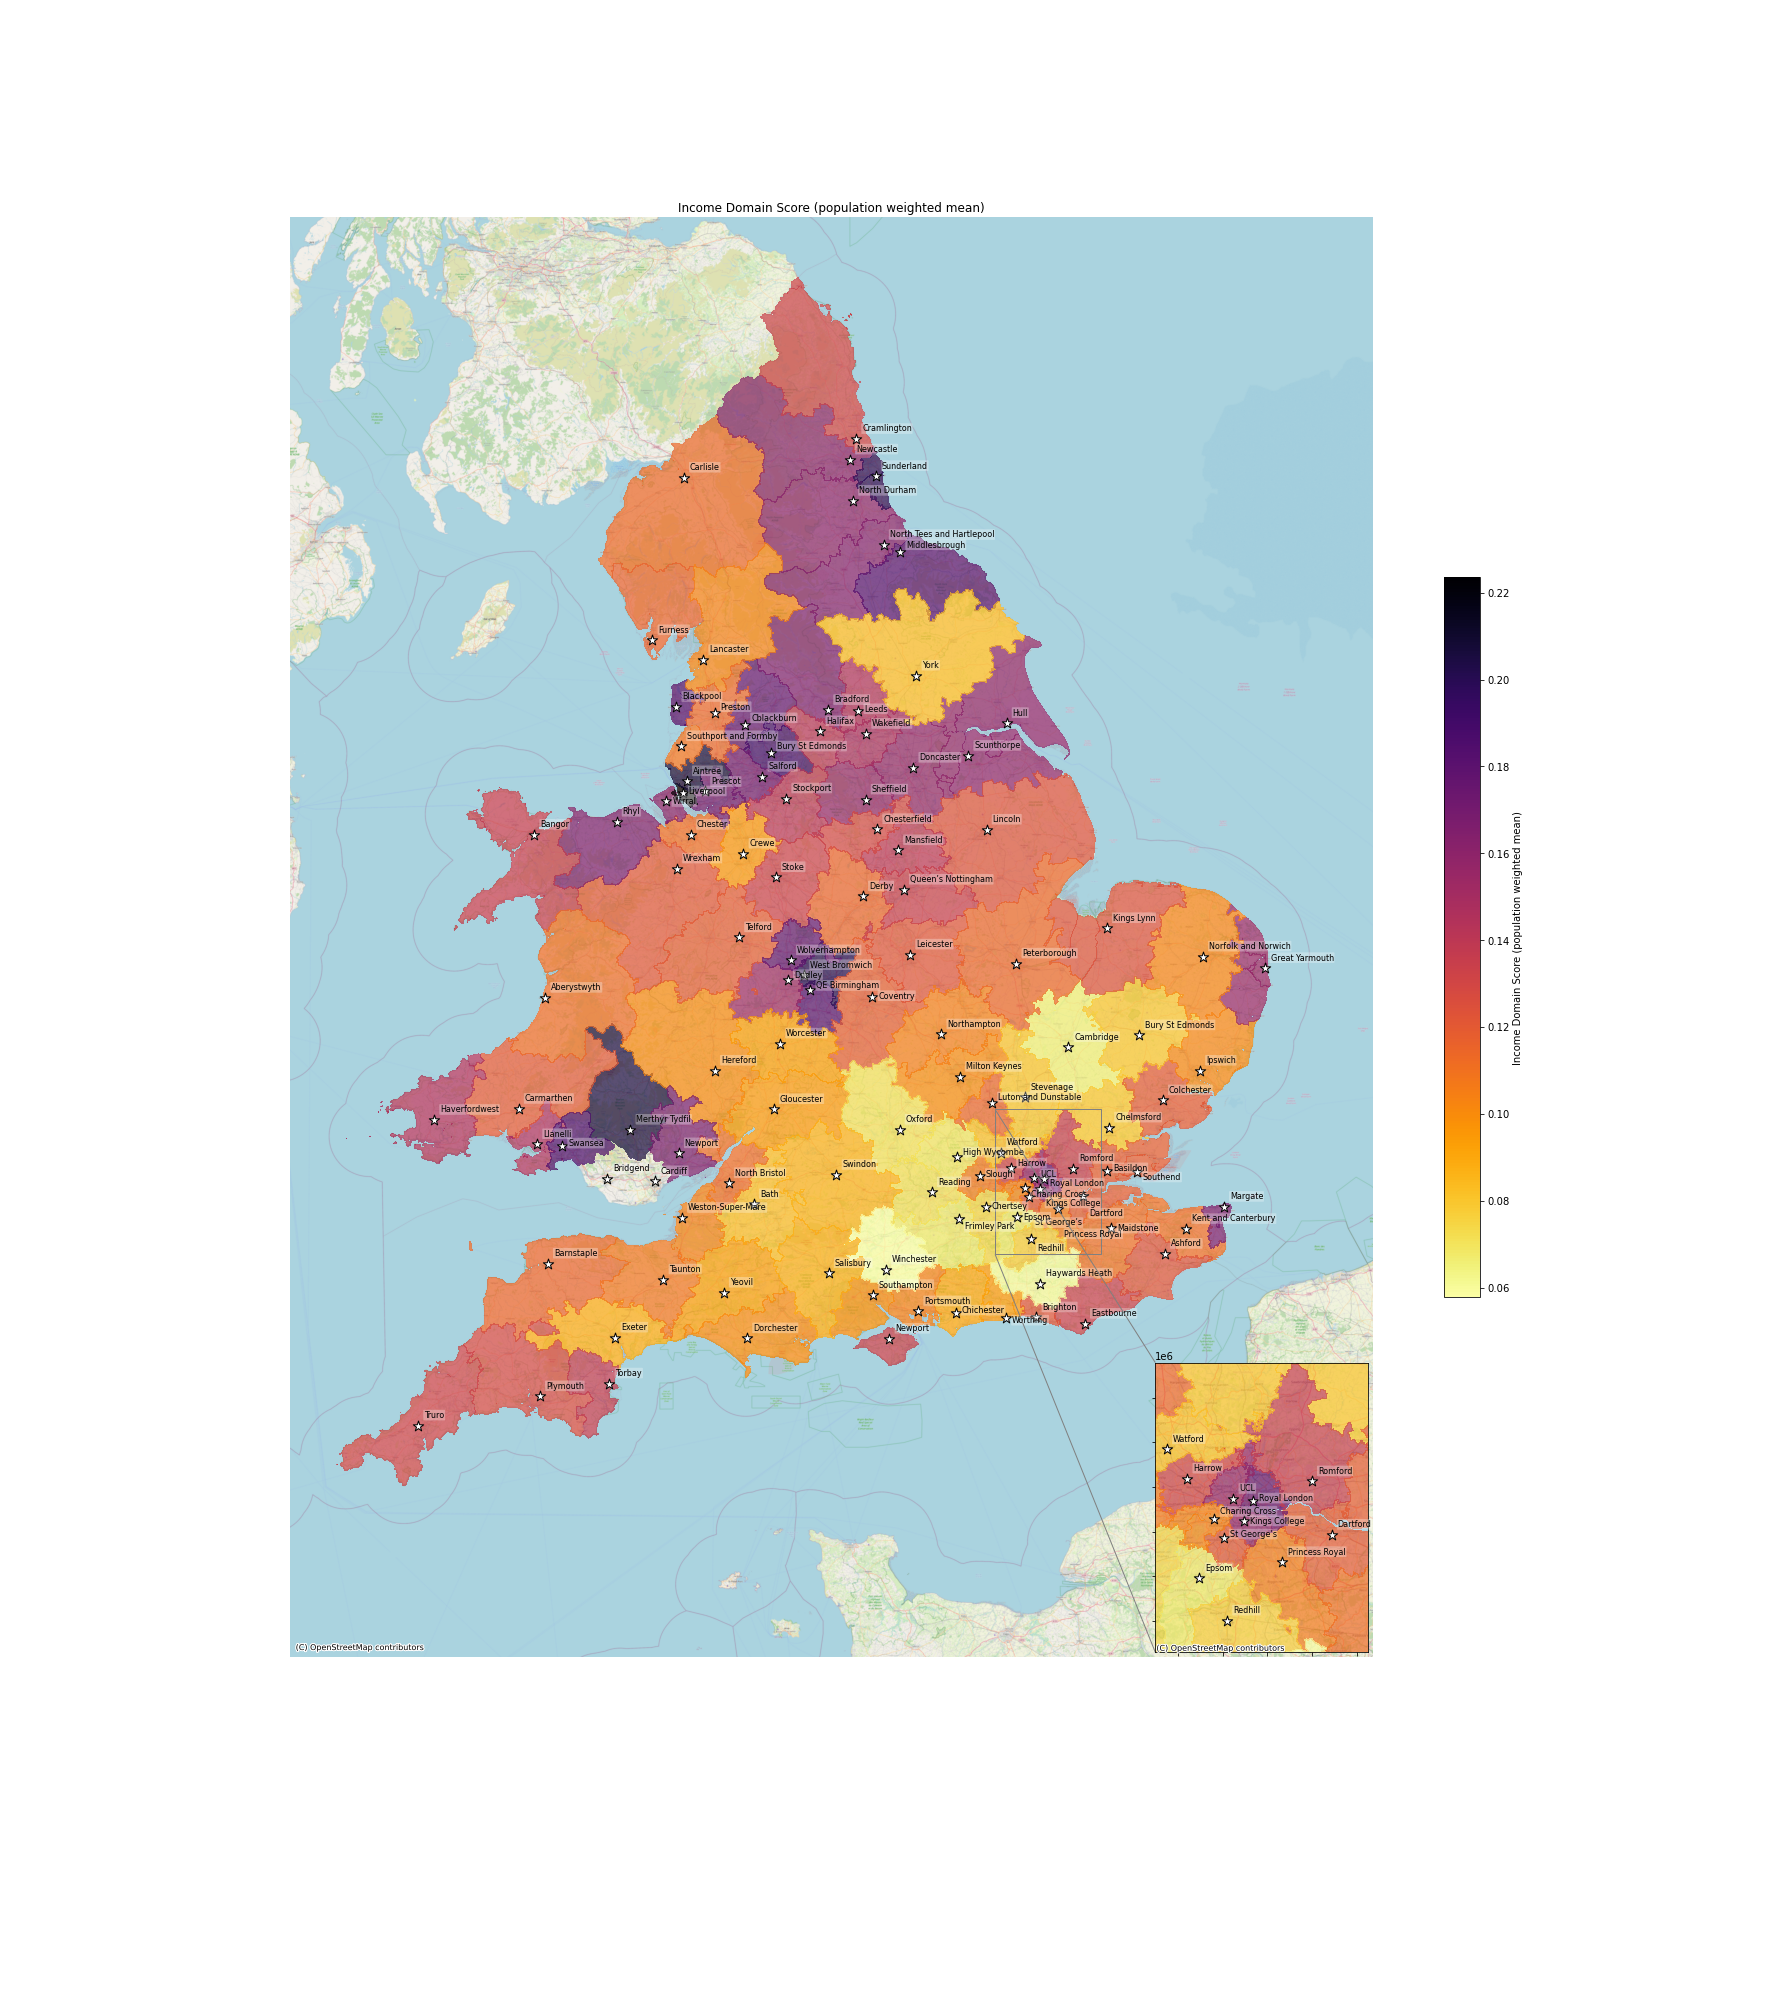

In [12]:
show_labels = True

col = 'income_domain_score_weighted_mean'
col_readable = 'Income Domain Score (population weighted mean)'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')


if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)



# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Insert an inset map (loc=4 places it bottom right)
axins = zoomed_inset_axes(ax, 2, loc=4)

# Identify london hospitals to go in the inset map
mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    minx,miny,maxx,maxy =  eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)


# Plot location of hospitals
gdf_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(gdf_units, axins, 'hospital_city',
                                        y_step=0.05, fontsize=8)
    
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax=axins, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}.jpg', dpi=300) # Save figure
plt.show()